# Technology Conference Aggregation and Analysis Project
### Data Ingest and Processing
### April 8, 2020

## Importing Modules and Retrieving Custom Functions

For this project, I chose to primarily use the Python requests modules to interact with several conference websites and BeautifulSoup to parse and format/extract data. In some cases where rendering of client-side JavaScript was required to interact with pages, I used Selenium webdriver to access data through an automated headless Firefox browser window. I used Azure Cosmos DB as a cloud-based database-as-a-service (DBaaS) with the Python Azure software development kit (SDK) to interact with the database where I stored intermediate results from the website mining.

To streamline web scraping, I created multiple custom functions for generating scraper script metadata, starting preconfigured headless browsers and setting time limits for scripts. This allows a script to be scheduled on a laptop, virtual machine, or even an inexpensive single-board computer (SBC) such as a Raspberry Pi. A Pi is a good choice for longer term projects because scraping from sites is not computation intensive, but requires time to fetch thousands of individual pages without overloading the web servers. There are ARM-compatible web drivers that can automate Firefox for this purpose.

## Event Websites
There are a number of sites that aggregate technology conferences, although no one site has an exhaustive worldwide list of events. This site has thousands of events broken out by city/country and broad category, such as technology conference. The location/categories are listed at links at https://www.eventbrite.com/directory/sitemap/. This notebook is focused on this site, but the same principles apply to other sites.

In [22]:
# Import modules
from bs4 import BeautifulSoup
from random import shuffle
from datetime import datetime
import os
import json
import sys
import requests
import time
import socket
import io
from IPython.core.display import Image, display, HTML
from PIL import Image as Im

# Set parameters
TIME_LIMIT = 3600
WAIT_TIME = 4

# Demo flag. Set to False to turn on/off additional feedback
DEMO = True

# Fetch path of notebook. Not required for regular Python scripts
__file__ = os.path.join(os.getcwd(), 'datamining.ipynb')
print(__file__)

# Get local folder and add project folder to PATH
workingdir = os.getcwd()
sys.path.insert(0, workingdir)
parentdir = os.path.dirname(workingdir)
sys.path.insert(0, parentdir)

# Import custom modules
from utils.scraping import headless_browser, date_parse, update_time, scraper_info

# Get scraper info
scraperip, hostname, scriptname, dtg, start_time = scraper_info(__file__, DEMO)

# Hides code in HTML output
HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

/home/pi/capstone/notebooks/Untitled.ipynb
Getting scraper info...
IP: XXX.XXX.XXX.XXX; Host: XXXX; script: Untitled.ipynb; DTG: 2020-04-29 18:53:35


In [23]:
# Start headless browser and fetch page info
browser = headless_browser(__file__, DEMO)
useragent = browser.execute_script("return navigator.userAgent;")
print("XXXXXXXXXXXXXXX" + useragent[-30:])

Appending /home/pi/capstone/notebooks to PATH...
Saving browser log to /home/pi/capstone/notebooks/log/934146.log
Platform: Linux-4.19.114-v7l+-armv7l-with-debian-10.3... Using geckodriver_23_arm7 geckodriver executable...
XXXXXXXXXXXXXXX0) Gecko/20100101 Firefox/75.0


## Searching Websites with Python and Selenium
We could use the requests library to get individual recipes based on URL, but to get a list of URLs, we need to use the site's search tool and filters. To avoid doing this manually and programatically navigate the search page, we will use Selenium.

Selenium is a tool that automates browsers, such as Chrome or Firefox. Selenium is primarily used for testing websites, but can also be used to navigate and scrape data from them. The Selenium driver for Firefox also supports headless browsing, meaning we can launch the browser in the background without graphical resources and execute and interact with any Javascript-based rendering or form elements. Web scraping through an automated browser is slower than executing direct requests through Python, but often the limiting factor for scraping is Internet bandwidth and web server resources. In addition, with browser automation we can do more than retrieve just the source HTML from the page including rendering and creating screenshots of webpages

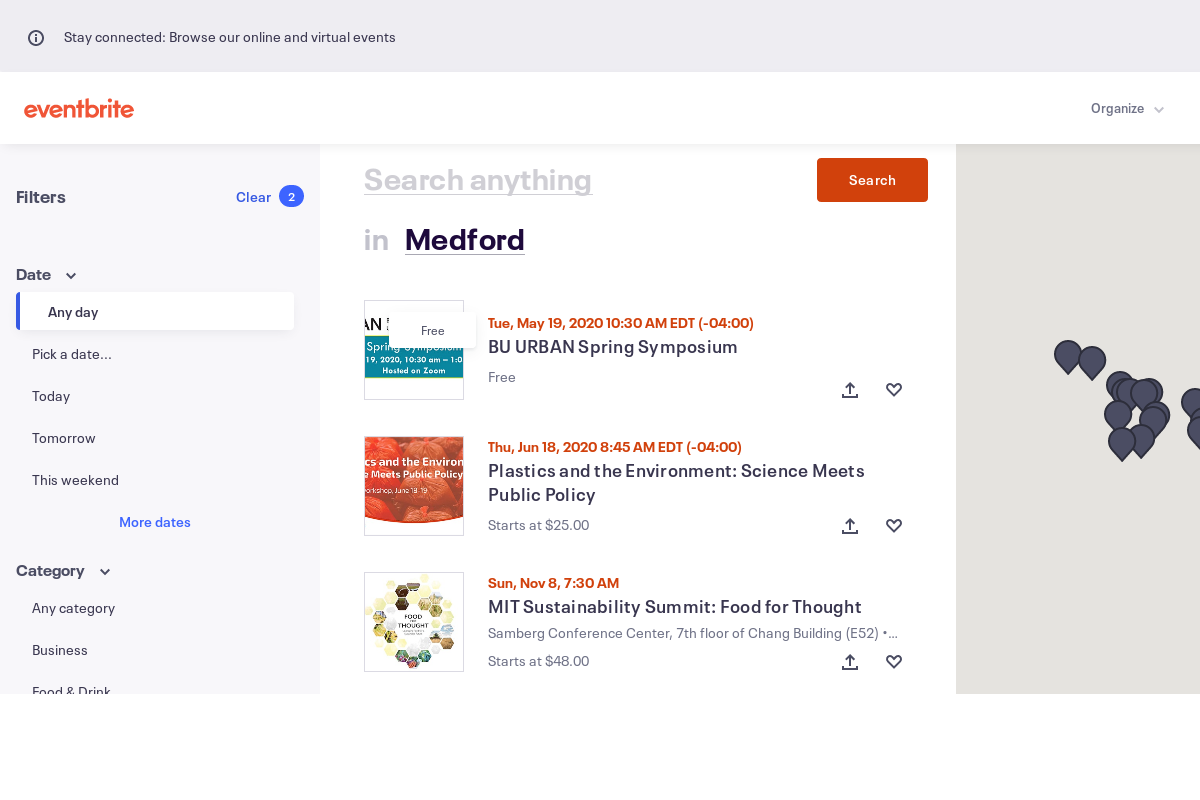

In [33]:
# Fetch webpage
srcurl = 'https://www.eventbrite.com/d/ma--medford/science-and-tech--conferences/'
browser.get(srcurl)
time.sleep(2)

# Render screenshot of page
png1 = browser.get_screenshot_as_png()
display(Im.open(io.BytesIO(png1)).crop((0,0,1200,800)))

Once the search page results are loaded with Selenium, we need to determine the pagination count and then fetch the event URLs from each list of paginated results.

In [36]:
# Find pagination number of result pages to fetch
src = browser.page_source
soup = BeautifulSoup(src, 'html.parser')
try:
    pages = int(soup.find(
        "div", attrs={"data-spec": "paginator__last-page-link"}).text.replace('.', ''))
except Exception:
    try:
        pages = int(soup.find("li", attrs={
                    "data-spec": "eds-pagination__navigation-minimal"}).text.split('of')[-1].strip())
    except Exception:
        pages = 1
print(str(pages) + ' pages found.')

# Process pages
foundurls = []
for page1 in range(1, pages + 1):
    dtg = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    jsons = []
    try:
        in1 = list(
            set(soup.find_all("script", attrs={"type": "application/ld+json"})))
        jsons = json.loads(str(in1[0].text))
        print(str(len(jsons)) + ' events found on current page. ' + str(len(foundurls) + len(jsons)) + ' total events founds.')
    except Exception:
        try:
            browser.get(srcurl)
        except Exception:
            pass
        time.sleep(10)
        src = browser.page_source
        soup = BeautifulSoup(src, 'html.parser')
        jsons = []
        try:
            in1 = list(
                set(soup.find_all("script", attrs={"type": "application/ld+json"})))
            jsons = json.loads(str(in1[0].text))
            print(str(len(jsons)) + ' events found on current page ' + str(len(foundurls) + len(jsons)) + ' total events founds.')
        except Exception:
            jsons = []
            print('no events found...')
    for json1 in jsons:
        dtg = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        result1 = {}
        result1['dtg'] = dtg
        result1['hostname'] = hostname
        result1['scriptname'] = scriptname
        result1['srcurl'] = srcurl
        result1['useragent'] = useragent
        result1['pagetitle'] = soup.title.text.strip()
        try:
            result1['name'] = json1['name'].strip()
        except Exception:
            pass
        try:
            result1['eventurl'] = json1['url']
            result1['eid'] = result1['eventurl'].split('-')[-1]
        except Exception:
            pass
        try:
            result1['description'] = json1['description'].strip()
        except Exception:
            pass
        try:
            result1['startDate'] = str(json1['startDate']) + ' 00:00:00'
        except Exception:
            pass
        try:
            result1['endDate'] = json1['endDate'] + ' 00:00:00'
        except Exception:
            pass
        try:
            result1['lowPrice'] = str(
                json1['offers']['priceCurrency']) + ' ' + str(json1['offers']['lowPrice'])
        except Exception:
            pass
        try:
            result1['highPrice'] = str(
                json1['offers']['priceCurrency']) + ' ' + str(json1['offers']['highPrice'])
        except Exception:
            pass
        try:
            result1['venuename'] = json1['location']['name'].strip()
        except Exception:
            pass
        try:
            result1['streetAddress'] = json1['location']['address']['streetAddress'].strip(
            )
        except Exception:
            pass
        try:
            result1['locality'] = json1['location']['address']['addressLocality'].strip()
        except Exception:
            pass
        try:
            result1['region'] = json1['location']['address']['addressRegion'].strip()
        except Exception:
            pass
        try:
            result1['country'] = json1['location']['address']['addressCountry']['name'].strip()
        except Exception:
            pass
        try:
            result1['latitude'] = round(
                float(json1['location']['geo']['latitude']), 7)
        except Exception:
            pass
        try:
            result1['longitude'] = round(
                float(json1['location']['geo']['longitude']), 7)
        except Exception:
            pass
        if result1['name'] != '' and not result1['eventurl'] in foundurls:
            foundurls += [result1['eventurl']]
    elapsed_time = int(time.time() - start_time)
    if page1 < pages:
        print(str(elapsed_time) + ' seconds elapsed. starting page number ' + str(page1 + 1) + ' of ' + str(pages))
        try:
            browser.get(srcurl + '?page=' + str(page1))
        except Exception:
            pass
        time.sleep(3)
        src = browser.page_source
        soup = BeautifulSoup(src, 'html.parser')
        # Increment and show elapsed time until limit reached
        update_time(start_time, TIME_LIMIT, WAIT_TIME)

# Print sample of URLs
print('\n'.join(foundurls[:10]))

6 events found on current page. 6 total events founds.
606 seconds elapsed. starting page number 2 of 3
10 minutes elapsed...
20 events found on current page. 26 total events founds.
622 seconds elapsed. starting page number 3 of 3
10 minutes elapsed...
20 events found on current page. 46 total events founds.


## Scraping Individual Recipe Pages
With a list of event URLs, we can go to the next step and fetch each page. For the purpose of this demonstration, we will only look at one page, as scraping all the events from the website would take hours or even days. While we're using Selenium for this page to render a screenshot, we use BeautifulSoup to parse the HTML. BeautifulSoup is a library that can turn the source HTML into a searchable object tree in Python. In addition, some sites that use JQuery or other JavaScript libraries to search and render results may include formatted JSONs hidden in the source code itself. It takes additional steps including the Python JSON library, but this allows us to find structured metadata about events which can be converted to dictionaries. From there, we can selectively use that data to build and output a result dictionary.

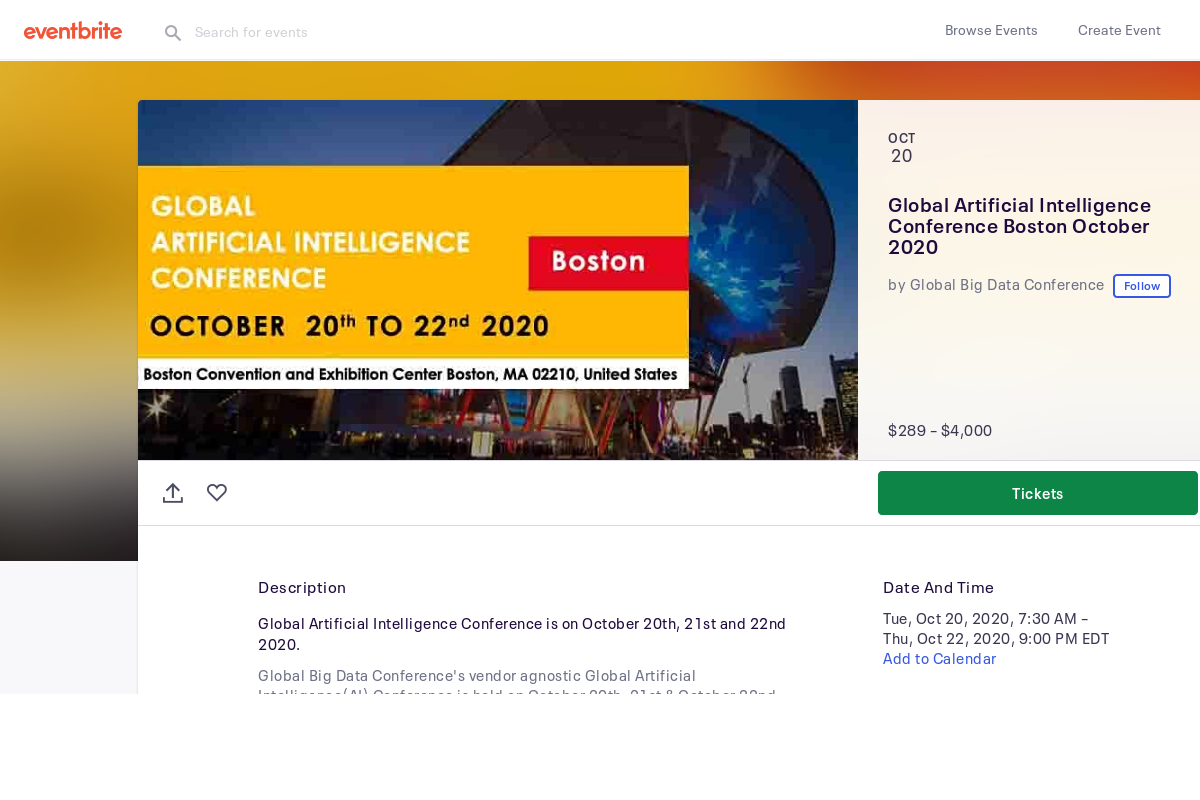

In [44]:
# Fetch webpage
srcurl = 'https://www.eventbrite.com/e/global-artificial-intelligence-conference-boston-october-2020-tickets-81221478629'
browser.get(srcurl)
time.sleep(2)

# Render screenshot of page
png1 = browser.get_screenshot_as_png()
display(Im.open(io.BytesIO(png1)).crop((0,0,1200,800)))

In [45]:
src = browser.page_source
soup = BeautifulSoup(src, 'html.parser')
result = {}
result['srcurl'] = srcurl
result['eventurl'] = srcurl
result['dtg'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Findings field values using BeautifulSoup
if not DEMO:
    try:
        result['scraperip'] = scraperip
    except Exception:
        pass
    try:
        result['hostname'] = hostname
    except Exception:
        pass
else:
    result['scraperip'] = 'XXX.XXX.XXX.XXX'
    result['hostname'] = 'XXXX'
try:
    result['scriptname'] = scriptname
except Exception:
    pass
try:
    result['eid'] = result['eventurl'].split('-')[-1]
except Exception:
    pass
result['name'] = ''
try:
    result['name'] = json.loads(soup.find("script", attrs={
                                "type": "application/ld+json"}).text, strict=False)['name'].strip()
except Exception:
    pass
try:
    result['description'] = json.loads(soup.find("script", attrs={
                                       "type": "application/ld+json"}).text, strict=False)['description'][:2000].strip()
except Exception:
    pass
try:
    result['startDate'] = json.loads(soup.find("script", attrs={
                                     "type": "application/ld+json"}).text, strict=False)['startDate'].split('T')[0] + ' 00:00:00'
except Exception:
    pass
try:
    result['endDate'] = json.loads(soup.find("script", attrs={
                                   "type": "application/ld+json"}).text, strict=False)['endDate'].split('T')[0] + ' 00:00:00'
except Exception:
    pass
try:
    result['venuename'] = json.loads(soup.find("script", attrs={
                                     "type": "application/ld+json"}).text, strict=False)['location']['name']
except Exception:
    pass
try:
    result['streetAddress'] = json.loads(soup.find("script", attrs={
                                         "type": "application/ld+json"}).text, strict=False)['location']['address']['streetAddress']
except Exception:
    pass
try:
    result['locality'] = json.loads(soup.find("script", attrs={
                                    "type": "application/ld+json"}).text, strict=False)['location']['address']['addressLocality']
except Exception:
    pass
try:
    result['region'] = json.loads(soup.find("script", attrs={
                                  "type": "application/ld+json"}).text, strict=False)['location']['address']['addressRegion']
except Exception:
    pass
try:
    result['country'] = json.loads(soup.find("script", attrs={
                                   "type": "application/ld+json"}).text, strict=False)['location']['address']['addressCountry']
except Exception:
    pass
try:
    result['latitude'] = soup.find(
        "meta", attrs={"property": "event:location:latitude"})['content'].strip()
except Exception:
    pass
try:
    result['longitude'] = soup.find(
        "meta", attrs={"property": "event:location:longitude"})['content'].strip()
except Exception:
    pass
try:
    result['zipcode'] = json.loads(soup.find("script", attrs={
                                   "type": "application/ld+json"}).text, strict=False)['location']['address']['postalCode'].strip()
except Exception:
    pass
try:
    result['category'] = soup.find("a", attrs={
                                   "data-event-category": "listing"}).parent.parent.get_text('|').replace('\n|', '').strip()[:-1]
except Exception:
    pass
try:
    result['lowPrice'] = str(json.loads(soup.find("script", attrs={"type": "application/ld+json"}).text, strict=False)['offers'][0]['priceCurrency']) + ' ' + str(
        json.loads(soup.find("script", attrs={"type": "application/ld+json"}).text, strict=False)['offers'][0]['lowPrice'])
except Exception:
    pass
try:
    result['highPrice'] = str(json.loads(soup.find("script", attrs={"type": "application/ld+json"}).text, strict=False)['offers'][0]['priceCurrency']) + ' ' + str(
        json.loads(soup.find("script", attrs={"type": "application/ld+json"}).text, strict=False)['offers'][0]['highPrice'])
except Exception:
    pass
try:
    result['organizer'] = json.loads(soup.find("script", attrs={
                                     "type": "application/ld+json"}).text, strict=False)['organizer']['name'].strip()
except Exception:
    pass

print(json.dumps(result, indent=2, sort_keys=True))

{
  "category": "United States Events|Massachusetts Events|Things to do in Boston, MA|Boston Conferences|Boston Science & Tech Conferences",
  "country": "US",
  "description": "Global\u00a0Artificial Intelligence Conference is on October 20th, 21st and 22nd 2020.\r\nGlobal Big Data Conference's vendor agnostic Global Artificial Intelligence(AI) Conference is held on October 20th. 21st & October 22nd 2020 on all industry verticals(Finance, Retail/E-Commerce/M-Commerce, Healthcare/Pharma/BioTech, Energy, Education, Insurance, Manufacturing, Telco, Auto, Hi-Tech, Media, Agriculture, Chemical, Government, Transportation etc.. ). It will be the largest vendor agnostic conference in AI space. The Conference allows practitioners to discuss AI through effective use of various techniques.  Large amount of data created by various mobile platforms, social media interactions, e-commerce transactions, and IoT provide an opportunity for businesses to effectively tailor their services by effective u

Once the results are formatted as a dictionary they can be saved as a JSON and/or uploaded to a document database such as Cosmos DB or Mongo DB. Document DBs are a type of NoSQL database which can be schema-less. The advantage with this approach is that we can build formatted document entries with only the metadata found from each site. As new sites are added with different metadata, document databases are flexible enough to incorporate new data since there is no fixed schema. However, it is helpful to adhere to data validation and reuse common key names such as latitude/longitude, so that the data can be easily retrieved and analyzed later on. I include some additional script metadata to help with troubleshooting parsing issues.